# ML Workbench Sample --- Image Classification

<br><br>
### _Introduction of ML Workbench_
ML Workbench provides an easy command line interface for machine learning life cycle, which involves four stages:
* analyze: gather stats and metadata of the training data, such as numeric stats, vocabularies, etc. Analysis results are used in transforming raw data into numeric features, which can be consumed by training directly.  
* transform: explicitly transform raw data into numeric features which can be used for training.
* train: training model using transformed data.
* predict/batch_predict: given a few instances of prediction data, make predictions instantly / with large number of instances of prediction data, make predictions in a batched fassion.


There are "local" and "cloud" run mode for each stage. "cloud" run mode is recommended if your data is big.
<br><br>
ML Workbench supports numeric, categorical, text, image training data. For each type, there are a set of "transforms" to choose from. The "transforms" indicate how to convert the data into numeric features. For images, it is converted to fixed size vectors representing high level features.
<br><br>

### _Transfer learning using ML Workbench - Local Run Experience_
ML Workbench supports image transforms (image to vec) with transfer learning.

Traditionally, image classification required a very large corpus of training data - often millions of images which may not be available and a long time to train on those images which is expensive and time consuming. That has changed with transfer learning which can be readily used with Cloud ML Engine and without deep knowledge of image classification algorithms using the ML Workbench in Datalab.

This notebook codifies the capabilities discussed in this [blog post](https://cloud.google.com/blog/big-data/2016/12/how-to-train-and-classify-images-using-google-cloud-machine-learning-and-cloud-dataflow). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. The pre-trained model is used to generate numeric features (image_to_vec transform). For explanation, simple flower images are used. Compared to training from scratch, the training data requirements, time and costs are drastically reduced.

This notebook does all operations in the Datalab container without calling CloudML API. Hence, this is called "local" operations - though Datalab itself is most often running on a GCE VM. See the corresponding cloud notebook for cloud experience which only adds the --cloud parameter and some config to the local experience commands. The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

In [1]:
# ML Workbench magics (%%ml) are under google.datalab.contrib namespace. It is not enabled by default and you need to import it before use.
import google.datalab.contrib.mlworkbench.commands

## Setup
All data is available under gs://cloud-datalab/sampledata/flower. eval100 is a subset of eval300, which is a subset of eval670. Same for training data.

In [5]:
!mkdir -p /content/datalab/flowerdata
!gsutil -m cp gs://cloud-datalab/sampledata/flower/* /content/datalab/flowerdata

Copying gs://cloud-datalab/sampledata/flower/all.csv...
Copying gs://cloud-datalab/sampledata/flower/eval100.csv...
Copying gs://cloud-datalab/sampledata/flower/eval300.csv...
Copying gs://cloud-datalab/sampledata/flower/eval670.csv...
Copying gs://cloud-datalab/sampledata/flower/train1000.csv...
Copying gs://cloud-datalab/sampledata/flower/train200.csv...
Copying gs://cloud-datalab/sampledata/flower/train300.csv...
Copying gs://cloud-datalab/sampledata/flower/train3000.csv...


Define directories for preprocessing, model, and prediction.

In [1]:
worker_dir = '/content/datalab/tmp/flower'

# analysis results dir
analysis_dir = worker_dir + '/analysis'

# transformed results dir
transform_dir = worker_dir + '/transform'

# transformed training files
transformed_train = worker_dir + '/transform/train-*'

# transformed eval files
transformed_eval = worker_dir + '/transform/eval-*'

# model dir containing trained models
model_dir = worker_dir + '/model'

# training produces two models: one for prediction (data with no "truth")
prediction_model_dir = model_dir + '/model'

# the other for evaluation (data with "truth")
evaluation_model_dir = model_dir + '/evaluation_model'

# prediction data dir.
prediction_dir = worker_dir + '/predict'

# Local images dir
images_dir = worker_dir + '/images'

# Local training csv files
local_train_file = '/content/datalab/flowerdata/train200local.csv'
local_eval_file = '/content/datalab/flowerdata/eval100local.csv'

# Local eval csv files with images embedded. Used for batch prediction.
local_eval_file_embedded = '/content/datalab/flowerdata/eval100localembedded.csv'

# Batch prediction output file.
prediction_output_file = prediction_dir + '/predict_results_eval100localembedded.csv'

In order to get best efficiency, we download the images to local disk, and create our training and evaluation files to reference local path instead of GCS path. Note that the original training files referencing GCS image paths work too, although a bit slower.

In [2]:
!mkdir -p $images_dir

In [8]:
import csv
import datalab.storage as gcs
import os


def download_images(input_csv, output_csv, images_dir):
    with open(input_csv) as csvfile:
        data = list(csv.DictReader(csvfile, fieldnames=['image_url', 'label']))
    for x in data:
        url = x['image_url']
        out_file = os.path.join(images_dir, os.path.basename(url))
        with open(out_file, 'w') as f:
          f.write(gcs.Item.from_url(url).read_from())
        x['image_url'] = out_file

    with open(output_csv, 'w') as w:
        csv.DictWriter(w, fieldnames=['image_url', 'label']).writerows(data)


download_images('/content/datalab/flowerdata/train200.csv', local_train_file, images_dir)    
download_images('/content/datalab/flowerdata/eval100.csv', local_eval_file, images_dir)

The above code can best be illustrated by the comparison below.

In [4]:
!head /content/datalab/flowerdata/train200.csv -n 5

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy


In [5]:
!head {local_train_file} -n 5

# Analyze

Analysis step includes computing numeric stats (i.e. min/max), categorical classes, text vocabulary and frequency, etc. Run "%%ml analyze --help" for usage. The analysis results will be used for transforming raw data into numeric features that the model can deal with. For example, to convert categorical value to a one-hot vector ("Monday" becomes [1, 0, 0, 0, 0, 0, 0]). The data may be very large, so sometimes a cloud run is needed by adding --cloud flag.  

In this case, analysis step only collects unique labels.

Note that we run analysis only on training data, but not evaluation data.

In [9]:
%%ml analyze
output: $analysis_dir
training_data:
    csv: $local_train_file
    schema:
      - name: image_url
        type: STRING
      - name: label
        type: STRING
features:
    image_url:
        transform: image_to_vec
    label:
        transform: target

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/flowerdata/train200local.csv...
file /content/datalab/flowerdata/train200local.csv analyzed.


In [15]:
!ls $analysis_dir

features.json  schema.json  stats.json	vocab_label.csv


# Transform

With analysis results we can transform raw data into numeric features. This needs to be done for both training and eval data. The data may be very large, so sometimes a cloud pipeline is needed by adding --cloud.

In this case, transform is required. It downloads image, resizes it, and generate embeddings from each image by running a pretrained TensorFlow graph.

In [16]:
# Delete existing transform output data
!rm -r -f $transform_dir

Transform training data.

In [17]:
%%ml transform
analysis: $analysis_dir
prefix: train
output: $transform_dir 
training_data:
    csv: $local_train_file

2017-07-17 17:32:05.313769: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:05.313798: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:05.313809: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:05.313818: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:05.313827: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

Transform eval data.

In [18]:
%%ml transform
analysis: $analysis_dir
prefix: eval
output: $transform_dir
training_data:
    csv: $local_eval_file

2017-07-17 17:32:45.864655: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:45.864683: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:45.864695: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:45.864705: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-17 17:32:45.864714: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [14]:
!ls $transform_dir -l -h

total 2.2M
-rw-r--r-- 1 root root    0 Jul 17 17:27 errors_eval-00000-of-00001.txt
-rw-r--r-- 1 root root    0 Jul 17 17:26 errors_train-00000-of-00001.txt
-rw-r--r-- 1 root root 718K Jul 17 17:27 eval-00000-of-00001.tfrecord.gz
-rw-r--r-- 1 root root 1.5M Jul 17 17:26 train-00000-of-00001.tfrecord.gz


# Train

Training starts from transformed data. If training work is too much to do on the local VM, --cloud is recommended so training happens in cloud, in a distributed way. Run %%ml train --help for details.

In [12]:
# Removing existing training files if exist.
!rm -r -f $model_dir

In [13]:
%%ml train
output: $model_dir
analysis: $analysis_dir
training_data:
    transformed: $transformed_train
evaluation_data:
    transformed: $transformed_eval
model_args:
    model: dnn_classification
    hidden-layer-size1: 100
    max-steps: 800
    top-n: 2

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47bc33ff50>, '_model_dir': '/content/datalab/tmp/flower/model/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of t

In [4]:
# Start a tensorboard hosted in Datalab.

from google.datalab.ml import TensorBoard

TensorBoard.start(model_dir);

TensorBoard was started successfully with pid 400. Click here to access it.

# Prediction

There are two types of prediction: instant and batch. Instant prediction works for small instances of data and the results come back instantly. The prediction data is provided in http request (cloud run) or in input cell (local run).

In [6]:
# Get some prediction data
!head $local_eval_file

INFO:tensorflow:Restoring parameters from /content/datalab/tmp/flower/model/model/variables/variables


predicted,predicted_2,predicted_3,predicted_4,predicted_5,score,score_2,score_3,score_4,score_5,flower,flower_image
daisy,sunflowers,dandelion,tulips,roses,0.999997,2.615114e-06,1.166369e-08,2.447131e-10,3.990788e-15,/content/datalab/tmp/flower/images/15...,
daisy,sunflowers,dandelion,tulips,roses,0.999992,6.262736e-06,1.602038e-06,4.465300e-10,2.881921e-13,/content/datalab/tmp/flower/images/58...,
tulips,roses,dandelion,sunflowers,daisy,0.997596,2.363907e-03,4.022184e-05,5.775601e-09,8.868154e-11,/content/datalab/tmp/flower/images/13...,
roses,tulips,dandelion,sunflowers,daisy,0.999993,7.390135e-06,1.041455e-08,7.980820e-09,6.118641e-16,/content/datalab/tmp/flower/images/61...,
dandelion,roses,daisy,sunflowers,tulips,0.999997,2.588431e-06,2.681982e-08,2.882734e-09,4.808460e-11,/content/datalab/tmp/flower/images/26...,
dandelion,roses,daisy,sunflowers,tulips,1.000000,2.361999e-08,1.232023e-09,1.074111e-11,4.527075e-12,/content/datalab/tmp/flower/images/89...,
tulips,roses,dandelion,sunflowers,daisy,0.994872,5.127184e-03,3.197852e-07,5.734205e-09,7.472582e-13,/content/datalab/tmp/flower/images/37...,
tulips,roses,dandelion,sunflowers,daisy,0.999958,3.691990e-05,5.451494e-06,4.559231e-08,6.811106e-10,/content/datalab/tmp/flower/images/68...,

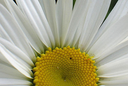
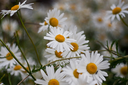
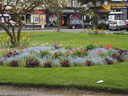
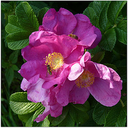
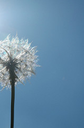
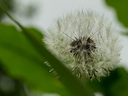
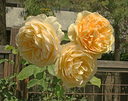
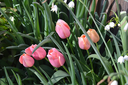

In [6]:
%%ml predict
model: $prediction_model_dir
headers: flower
image_columns: flower
prediction_data:
  - /content/datalab/tmp/flower/images/15207766_fc2f1d692c_n.jpg
  - /content/datalab/tmp/flower/images/5853276960_d08f90fff6.jpg
  - /content/datalab/tmp/flower/images/13857267684_d2a4b2630f_n.jpg
  - /content/datalab/tmp/flower/images/6111589202_8b9555364c_m.jpg
  - /content/datalab/tmp/flower/images/2634665077_597910235f_m.jpg
  - /content/datalab/tmp/flower/images/8980164828_04fbf64f79_n.jpg
  - /content/datalab/tmp/flower/images/3705716290_cb7d803130_n.jpg
  - /content/datalab/tmp/flower/images/6876631336_54bf150990.jpg

# Batch Prediction

Batch prediction performs prediction in a batched fashion. The data can be large, and is specified by files.  

In this case, there is an extra thing we need to do. We need to download images and replace image urls with resized image bytes. In the future, this step can be skipped and the local predictor and prediction service can do it for you but for the time being, it is required. It is only needed if you have image urls in your prediction data.

Note that, we use the "evaluation_model" which sits in "evaluation_model_dir". There are two models created in training. One is a regular model under "model" dir, the other is "evaluation_model". The difference is the regular one takes prediction data without target and the evaluation model takes data with target and output the target as is. So evaluation model is good for evaluating the quality of the model because the targets and predicted values are included in output.

In [8]:
import base64
from io import BytesIO
import csv
from PIL import Image


def embed_images(input_csv, headers, img_col, output_csv):
  with open(input_csv, 'r') as fr, open(output_csv, 'w') as fw:
    csv_reader = csv.DictReader(fr, fieldnames=headers)
    csv_writer = csv.DictWriter(fw, fieldnames=headers)
    for row in csv_reader:
      row_copy = dict(row)
      if not row[img_col]:
        continue
        
      with open(row[img_col], 'r') as f_image:
        im = Image.open(f_image)
        im.thumbnail((299, 299), Image.ANTIALIAS)
        buf = BytesIO()
        im.save(buf, "JPEG")
        content = base64.urlsafe_b64encode(buf.getvalue()).decode('ascii')
        row_copy[img_col] = content
      
      csv_writer.writerow(row_copy)

embed_images(local_eval_file, ['image', 'label'], 'image',  local_eval_file_embedded)      

In [9]:
%%ml batch_predict
model: $evaluation_model_dir
output: $prediction_dir
format: csv
batch_size: 20
prediction_data:
  csv: $local_eval_file_embedded

local prediction...
INFO:tensorflow:Restoring parameters from /content/datalab/tmp/flower/model/evaluation_model/variables/variables
done.


Check prediction results.

In [11]:
!ls $prediction_dir

predict_results_eval100localembedded.csv  predict_results_schema.json
predict_results_eval670localembedded.csv


In [21]:
!cd $prediction_dir && head predict_results_eval100localembedded.csv

daisy,dandelion,1.0,2.58378e-07,daisy
daisy,dandelion,0.99999,9.76342e-06,daisy
tulips,roses,0.993794,0.00618489,tulips
roses,tulips,0.999992,7.48505e-06,roses
dandelion,roses,0.999958,4.16e-05,dandelion
dandelion,roses,1.0,3.97741e-08,dandelion
tulips,roses,0.977736,0.0222639,roses
tulips,roses,0.999914,4.80119e-05,tulips
dandelion,sunflowers,0.999995,4.63635e-06,dandelion
sunflowers,dandelion,0.999955,4.51613e-05,sunflowers


It also produces an output schema which indicates what the columns are.

In [22]:
!cd $prediction_dir && cat predict_results_schema.json

[
  {
    "type": "STRING", 
    "name": "predicted"
  }, 
  {
    "type": "STRING", 
    "name": "predicted_2"
  }, 
  {
    "type": "FLOAT", 
    "name": "score"
  }, 
  {
    "type": "FLOAT", 
    "name": "score_2"
  }, 
  {
    "type": "STRING", 
    "name": "target"
  }
]

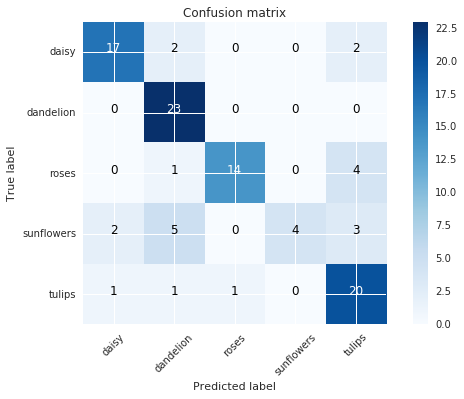

In [7]:
# Draw confusion matrix given the above using datalab's Confusion Matrix tool.
from google.datalab.ml import ConfusionMatrix

cm = ConfusionMatrix.from_csv(prediction_output_file, headers=['predicted', 'predicted2', 'score', 'score2', 'target'])
cm.plot()

In [24]:
# Compute accuracy
import pandas as pd
df = pd.read_csv(prediction_output_file, header=None, names=['predicted', 'predicted2', 'score', 'score2', 'target'])
correct = sum([1 if row['predicted'] == row['target'] else 0 for index, row in df.iterrows()])
accuracy = correct / float(len(df.index))
print('accuracy = %f' % accuracy)

accuracy = 0.780000


## Why Does My Model Predict this? Explained by LIME.

[LIME](https://github.com/marcotcr/lime) is an open sourced library performing feature sensitivity analysis. It is based on the work presented in [this paper](https://arxiv.org/abs/1602.04938). LIME is included in Datalab.

In this case, we use LIME to check which areas in a picture are contributing most to the predicted label. We pass our TensorFlow model based "prediction_fn" to LIME, and LIME perturbs the input values in the "neighborhood" of each data instance and gathers the prediction results. Based on these inputs and prediction results, LIME judges what features are "positive" and what are "negative" quantitatively. Note that LIME treats our TensorFlow model as a blackbox. It has no knowledge of the model itself. The results are purely based on perturbed inputs and their corresponding prediction output.

The use of LIME is for illustration and for gaining some insight into the TensorFlow model. The parameters we choose for LIME are specific to the demo scenario. Please consult LIME documents before adoption into your work.

If your model is deployed online, predictions will be done with http roundtrips and are restricted by http request size. Since LIME makes many predictions for a single instance, it is probably not a good idea to do it on deployed models.

In [2]:
from PIL import Image
from tensorflow.python.lib.io import file_io
import pandas as pd


labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# predict_fn is needed in lime explainer.

def predict_fn(images_in):
    """Give a list of images (RGB ndarray, channel = 3), output probs for each label for each instance."""

    images_data = []
    for im_rgb in images_in:
        im = Image.fromarray(im_rgb)
        images_data.append(im)
    images_data = pd.DataFrame(images_data, columns=['image'])
    df = mlw.get_prediction_results(prediction_model_dir, images_data, ['image'], img_cols=['image'], with_source=False)
    probs = mlw.get_probs_for_labels(labels, df)
    return probs


In [3]:
import google.datalab.contrib.mlworkbench as mlw

# Get some data from local_eval_file
# Run "!head $local_eval_file" to get below data
prediction_data = [
    '/content/datalab/tmp/flower/images/15207766_fc2f1d692c_n.jpg', # daisy
    '/content/datalab/tmp/flower/images/5853276960_d08f90fff6.jpg', # daisy
    '/content/datalab/tmp/flower/images/13857267684_d2a4b2630f_n.jpg', # tulips
    '/content/datalab/tmp/flower/images/6111589202_8b9555364c_m.jpg', # roses
    '/content/datalab/tmp/flower/images/2634665077_597910235f_m.jpg', # dandelion
    '/content/datalab/tmp/flower/images/8980164828_04fbf64f79_n.jpg', # dandelion
    '/content/datalab/tmp/flower/images/3705716290_cb7d803130_n.jpg', # roses
    '/content/datalab/tmp/flower/images/6876631336_54bf150990.jpg', # tulips
]

df = mlw.get_prediction_results(prediction_model_dir, prediction_data, ['image'], img_cols=['image'], with_source=False)
df

,predicted,predicted_2,probability,probability_2
0,daisy,sunflowers,0.999999,5.697997e-07
1,daisy,sunflowers,0.999992,6.982437e-06
2,tulips,roses,0.999858,1.400677e-04
3,roses,tulips,0.999998,2.381922e-06
4,dandelion,roses,1.000000,1.330132e-08
5,dandelion,tulips,1.000000,5.653647e-13
6,tulips,roses,0.997483,2.517465e-03
7,tulips,roses,0.999998,1.253838e-06


In [6]:
import numpy as np

prediction_images = []
for d in prediction_data:
    with file_io.FileIO(d, 'rb') as fi:
        im = Image.open(fi)
    im.thumbnail((299, 299), Image.ANTIALIAS)
    rgb_im = im.convert('RGB')
    prediction_images.append(np.asarray(rgb_im))

In [4]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

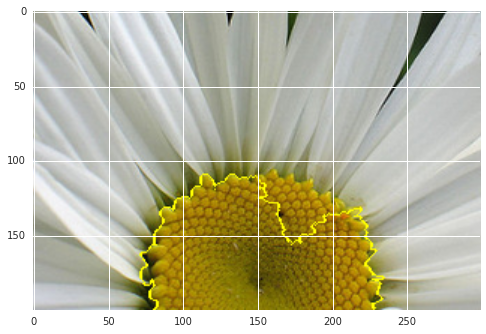

In [14]:
# Analyze prediction instance 0.

label_index = labels.index('daisy')

image = prediction_images[0]
explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, batch_size=500)
temp, mask = explanation.get_image_and_mask(label_index, positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

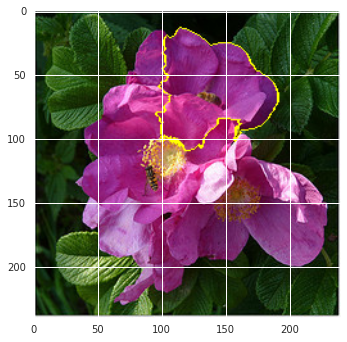

In [18]:
# Analyze prediction instance 3.

label_index = labels.index('roses')

image = prediction_images[3]
explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, batch_size=500)
temp, mask = explanation.get_image_and_mask(label_index, positive_only=True, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

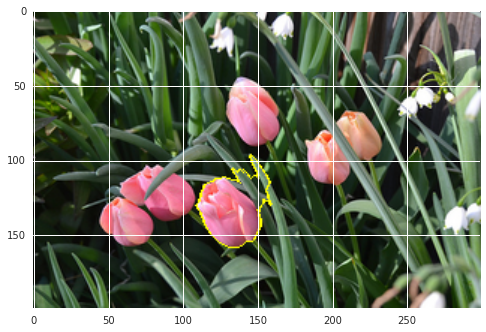

In [17]:
# Analyze prediction instance 7.

label_index = labels.index('tulips')

image = prediction_images[7]
explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, batch_size=500)
temp, mask = explanation.get_image_and_mask(label_index, positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

The instance 6 prediction results are incorrect. Truth is "roses" but it predicts "tulips". Let's analyze both true label and predicted label.

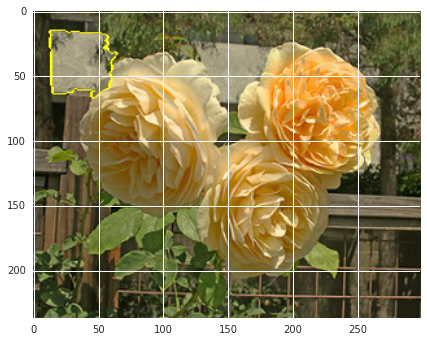

In [10]:
# Analyze prediction instance 6.
image = prediction_images[6]
explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, batch_size=500)

# Show what areas are contributing to "roses" 
true_label_index = labels.index('roses')
temp, mask = explanation.get_image_and_mask(true_label_index, positive_only=True, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

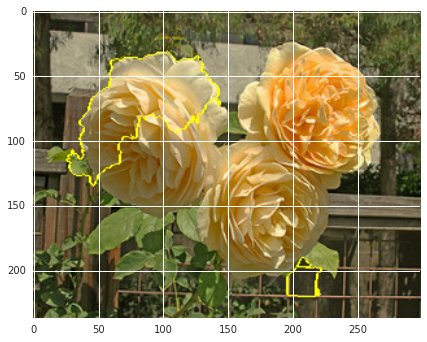

In [11]:
# Show what areas are contributing to "tulips"
predicted_label_index = labels.index('tulips')
temp, mask = explanation.get_image_and_mask(predicted_label_index, positive_only=True, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))